In [6]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Seeing how filters affect the posterior distribution of our galaxy

In [2]:
path_z = 'cosmos_3dhst.v4.1.cats/Eazy/cosmos_3dhst.v4.1.zout'
path_cat = 'cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat'

In [3]:
data_cat = np.genfromtxt(path_cat)
columns = np.loadtxt('column_names.txt', dtype=str)

In [7]:
df = pd.DataFrame(data = data_cat, columns = columns)

## Reducing down the dataframe to only the filters I have

HSC: g, r, i, z 

Irac: 3.8, 4.5

In [ ]:
my_science_filters = ['f_g', 'e_g', 'f_r', 'e_r', 'f_i', 'e_i', 
                   'f_z', 'i_z', 'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2']

In [8]:
some_cosmos_filters = ['f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 
                 'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2', 'f_IRAC3', 'e_IRAC3', 'f_IRAC4', 'e_IRAC4']

half_cosmos_filters = ['f_F814W', 'e_F814W', 'f_F160W', 'e_F160W', 'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2']

In [9]:
reduced_cosmos_df = df[some_cosmos_filters]

reduced_halfcosmos_df = df[half_cosmos_filters]

In [10]:
def correct_flux(flux):
    '''
    Function that converts the flux given in the cosmos catalog into fluxes that bagpipes
    can use which is microjansky. 
    
    Noting that the fluxes presented in the cosmos catalog are in: M_AB = 25 - 2.5log10(flux)
    and that the def of M_AB in jansky is: M_AB = 8.90 - 2.5log10(f_nu) I got the conversion factor below
    '''
    if flux < 0:
        return -99
    else:
        exponent = (25 - 8.9)/2.5
        conv = 10 ** (-exponent)
        proper_flux = flux * conv * 1e6
        
        return proper_flux

In [136]:
def load_cosmos_data(ID):
    '''
    This function gets passed into the Bagpipes fit class and what this will return
    is photometry data in the form of a 2D array with 2 columns w/ column1 = fluxes
    and column2 = flux_err.
    
    Parameter
    -----------------
    ID: string, float, int representing the ID number of the target you want to fit 
    
    Returns
    -----------------
    phot_2d_arr: 2d array of flux and flux errors for the filters I have.
    '''
    
    #getting the row value index
    row = int(ID) - 1
    
    #making empty list to hold flux and flux_err
    flux = []
    flux_err = []
    
    #filters in the dataframe
    filters = some_cosmos_filters
    
    #looping through the filters in the dataframe columns
    for filt in filters:
        
        #if it is an error append to the error list
        if 'e_' in filt:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux_err.append(proper_f)
        else:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux.append(proper_f)
    
    #making the two list into a 2d array
    phot_2d_arr = np.c_[flux, flux_err]
    
    #checking to see if I got some negative values cause that is no bueno and if I do
    #i set flux = 0 and blow up the error to a really high number
    
    for idx in range(len(phot_2d_arr)):
        if phot_2d_arr[idx][0] < 0 or phot_2d_arr[idx][1] < 0:
            phot_2d_arr[idx] = np.array([0, 9e99]) 
    
    return phot_2d_arr

In [12]:
def load_halfcosmos_data(ID):
    '''
    This function gets passed into the Bagpipes fit class and what this will return
    is photometry data in the form of a 2D array with 2 columns w/ column1 = fluxes
    and column2 = flux_err.
    
    Parameter
    -----------------
    ID: string, float, int representing the ID number of the target you want to fit 
    
    Returns
    -----------------
    phot_2d_arr: 2d array of flux and flux errors for the filters I have.
    '''
    
    #getting the row value index
    row = int(ID) - 1
    
    #making empty list to hold flux and flux_err
    flux = []
    flux_err = []
    
    #filters in the dataframe
    filters = half_cosmos_filters
    
    #looping through the filters in the dataframe columns
    for filt in filters:
        
        #if it is an error append to the error list
        if 'e_' in filt:
            f_obs = reduced_halfcosmos_df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux_err.append(proper_f)
        else:
            f_obs = reduced_halfcosmos_df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux.append(proper_f)
    
    #making the two list into a 2d array
    phot_2d_arr = np.c_[flux, flux_err]
    
    #checking to see if I got some negative values cause that is no bueno and if I do
    #i set flux = 0 and blow up the error to a really high number
    
    for idx in range(len(phot_2d_arr)):
        if phot_2d_arr[idx][0] < 0 or phot_2d_arr[idx][1] < 0:
            phot_2d_arr[idx] = np.array([0, 9e99]) 
    
    return phot_2d_arr

In [13]:
path = 'pipes/filters'
cosmos_filt = [path +'/HST_Filters/ACS_f606w.txt', path +'/HST_Filters/ACS_f814w.txt', path +'/HST_Filters/wfc_f140w.txt', path +'/HST_Filters/wfc_f160w.txt', 
             path +'/IRAC_Filters/IRAC_36_filt.txt', path +'/IRAC_Filters/IRAC_45_filt.txt', path +'/IRAC_Filters/IRAC_58_filt.txt', path +'/IRAC_Filters/IRAC_80_filt.txt']

In [137]:
path = 'pipes/filters'
half_cosmos_filt = [path +'/HST_Filters/ACS_f814w.txt', path +'/HST_Filters/wfc_f160w.txt', 
             path +'/IRAC_Filters/IRAC_36_filt.txt', path +'/IRAC_Filters/IRAC_45_filt.txt']

In [15]:
galaxy_cosmos = pipes.galaxy(405, load_cosmos_data, spectrum_exists=False, filt_list = cosmos_filt)

In [16]:
galaxy_halfcosmos = pipes.galaxy(405, load_halfcosmos_data, spectrum_exists=False, filt_list = half_cosmos_filt)

In [18]:
#Model Building 
model = {}
model['age'] = (.01, 13)
model['tau'] = (.02, 14)
model["metallicity"] = (0., 2.5)   
model["massformed"] = (1., 13.)  

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

#more complex dust modeling
##dust["qpah"] = (.01, 5.)          # PAH mass fraction
#dust["umin"] = (0., 4.)         # Lower limit of starlight intensity distribution
#dust["gamma"] = (0., 1.)      # Fraction of stars at umin

#nebular = {}
#nebular["logU"] = (1, 4.)


fit_instructions = {}
fit_instructions['delayed'] = model
fit_instructions['redshift'] = (0., 10)
fit_instructions['dust'] = dust
#fit_instructions['nebular'] = nebular

In [19]:
fit_cosmos = pipes.fit(galaxy_cosmos, fit_instructions)

In [20]:
fit_half_cosmos = pipes.fit(galaxy_halfcosmos, fit_instructions)

In [21]:
fit_cosmos.fit()


Bagpipes: fitting object 405


Completed in 107.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.623      1.587      3.591
delayed:massformed             6.582      8.496      8.714
delayed:metallicity            0.266      1.769      2.300
delayed:tau                    3.842      7.857     12.107
dust:Av                        0.132      0.449      1.528
redshift                       0.096      0.787      0.893




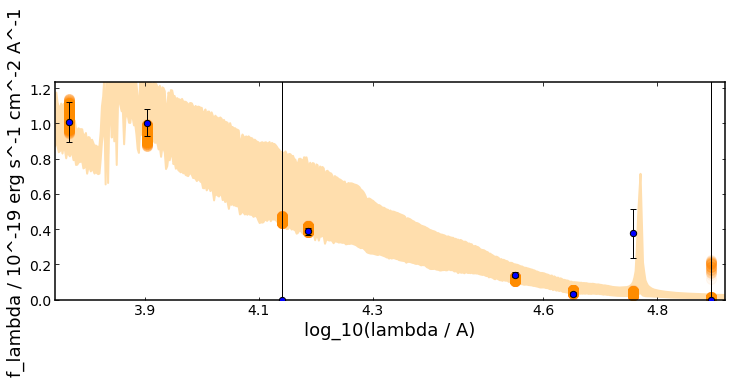

In [38]:
fig_cosmos = fit_cosmos.plot_spectrum_posterior(save=False, show=True)

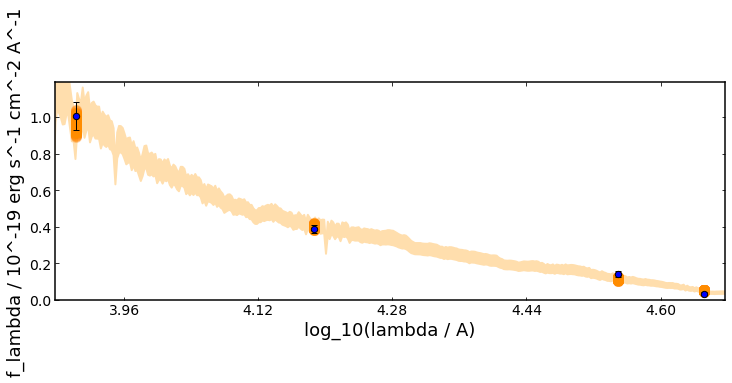

In [39]:
fig_half_cosmos = fit_half_cosmos.plot_spectrum_posterior(save=False, show=True)

In [22]:
fit_half_cosmos.fit()


Bagpipes: fitting object 405


Completed in 84.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.747      2.049      3.955
delayed:massformed             8.348      8.588      8.760
delayed:metallicity            1.239      1.968      2.343
delayed:tau                    3.680      8.011     12.039
dust:Av                        0.095      0.318      0.646
redshift                       0.721      0.831      0.933




In [23]:
fit_cosmos.posterior.samples.keys()

dict_keys(['delayed:age', 'delayed:massformed', 'delayed:metallicity', 'delayed:tau', 'dust:Av', 'redshift', 'stellar_mass', 'formed_mass', 'sfr', 'ssfr', 'nsfr', 'mass_weighted_age', 'tform', 'tquench', 'sfh'])

In [24]:
galaxy_properties = ['delayed:age', 'delayed:massformed', 'delayed:tau', 'dust:Av', 'redshift', 
                     'stellar_mass', 'formed_mass', 'sfr', 'ssfr', 'nsfr']

In [25]:
import matplotlib as mpl

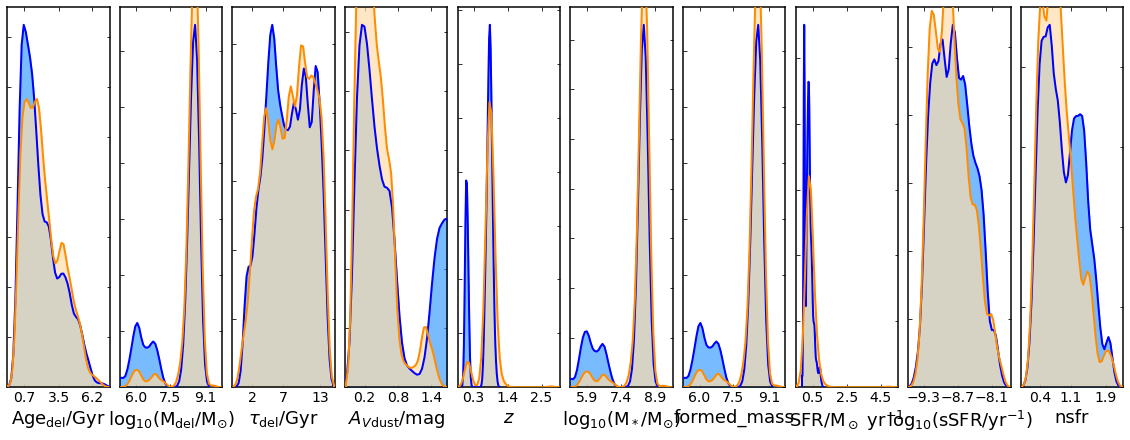

In [72]:
#mkaing a fig object
fig = plt.figure(figsize=(20, 7))

#getting gridspec layout
gs = mpl.gridspec.GridSpec(4, 10, hspace=3., wspace=0.1)

#making an axis object
ax1 = plt.subplot(gs[:4, :])

#posterior quantities (histograms)
post_quantities = dict(zip(galaxy_properties, [fit_cosmos.posterior.samples[l] for l in galaxy_properties]))
post_quantities_half = dict(zip(galaxy_properties, [fit_half_cosmos.posterior.samples[l] for l in galaxy_properties]))

axes = []

for i in range(10):
    axes.append(plt.subplot(gs[:4, i]))
    pipes.plotting.hist1d(post_quantities[galaxy_properties[i]], axes[-1], smooth=True, percentiles=False, color='blue')#, color = 'red' )#, label=galaxy_properties[i])

#posterior quantities (histograms)
#post_quantities_half = dict(zip(galaxy_properties, [fit_half_cosmos.posterior.samples[l] for l in galaxy_properties]))

#axes_ = []
#for i in range(10):
    #axes.append(plt.subplot(gs[:4, i]))
    pipes.plotting.hist1d(post_quantities_half[galaxy_properties[i]], axes[-1], smooth=True, label=galaxy_properties[i], percentiles=False)

In [74]:
percentile_whole = []
percentile_half = []

for i in range(10):
    
    percentile_whole.append(np.percentile(post_quantities[galaxy_properties[i]], [16, 84]))
    percentile_half.append(np.percentile(post_quantities_half[galaxy_properties[i]], [16, 84]))

In [75]:
percentile_whole

[array([0.60699785, 3.81425358]),
 array([6.45755483, 8.71744083]),
 array([ 4.04954856, 12.03795738]),
 array([0.13115906, 1.5590094 ]),
 array([0.08227988, 0.88282378]),
 array([6.28954675, 8.49604015]),
 array([6.45755483, 8.71744083]),
 array([0.00583903, 0.46685623]),
 array([-9.12837886, -8.37615026]),
 array([0.45191336, 1.41501144])]

In [76]:
percentile_half

[array([0.72532401, 3.92944473]),
 array([8.3408456, 8.76379  ]),
 array([ 4.02818951, 12.08831136]),
 array([0.0984693 , 0.65594233]),
 array([0.72414966, 0.93537123]),
 array([8.15931434, 8.54126955]),
 array([8.3408456, 8.76379  ]),
 array([0.20513687, 0.5351438 ]),
 array([-9.15435028, -8.44444449]),
 array([0.4251114 , 1.20436722])]

In [110]:
fifty_percentile_whole = []
fifty_percentile_half = []

for i in range(10):
    
    fifty_percentile_whole.append(np.percentile(post_quantities[galaxy_properties[i]], 50))
    fifty_percentile_half.append(np.percentile(post_quantities_half[galaxy_properties[i]], 50))

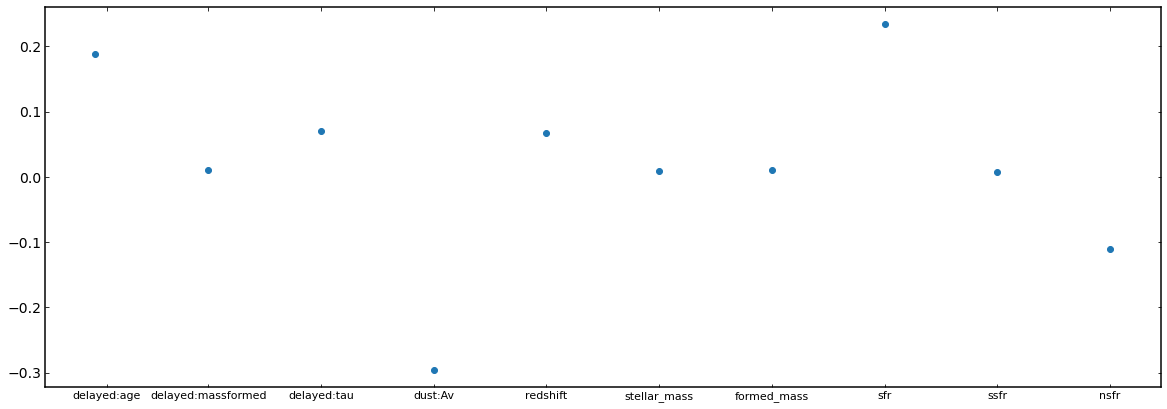

In [215]:
plt.figure(figsize = (20, 7))
plt.plot((np.array(fifty_percentile_half) - np.array(fifty_percentile_whole))/np.array(fifty_percentile_whole), 'o')
plt.xticks(ticks=[.1, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels = galaxy_properties, size = 11)
plt.show()

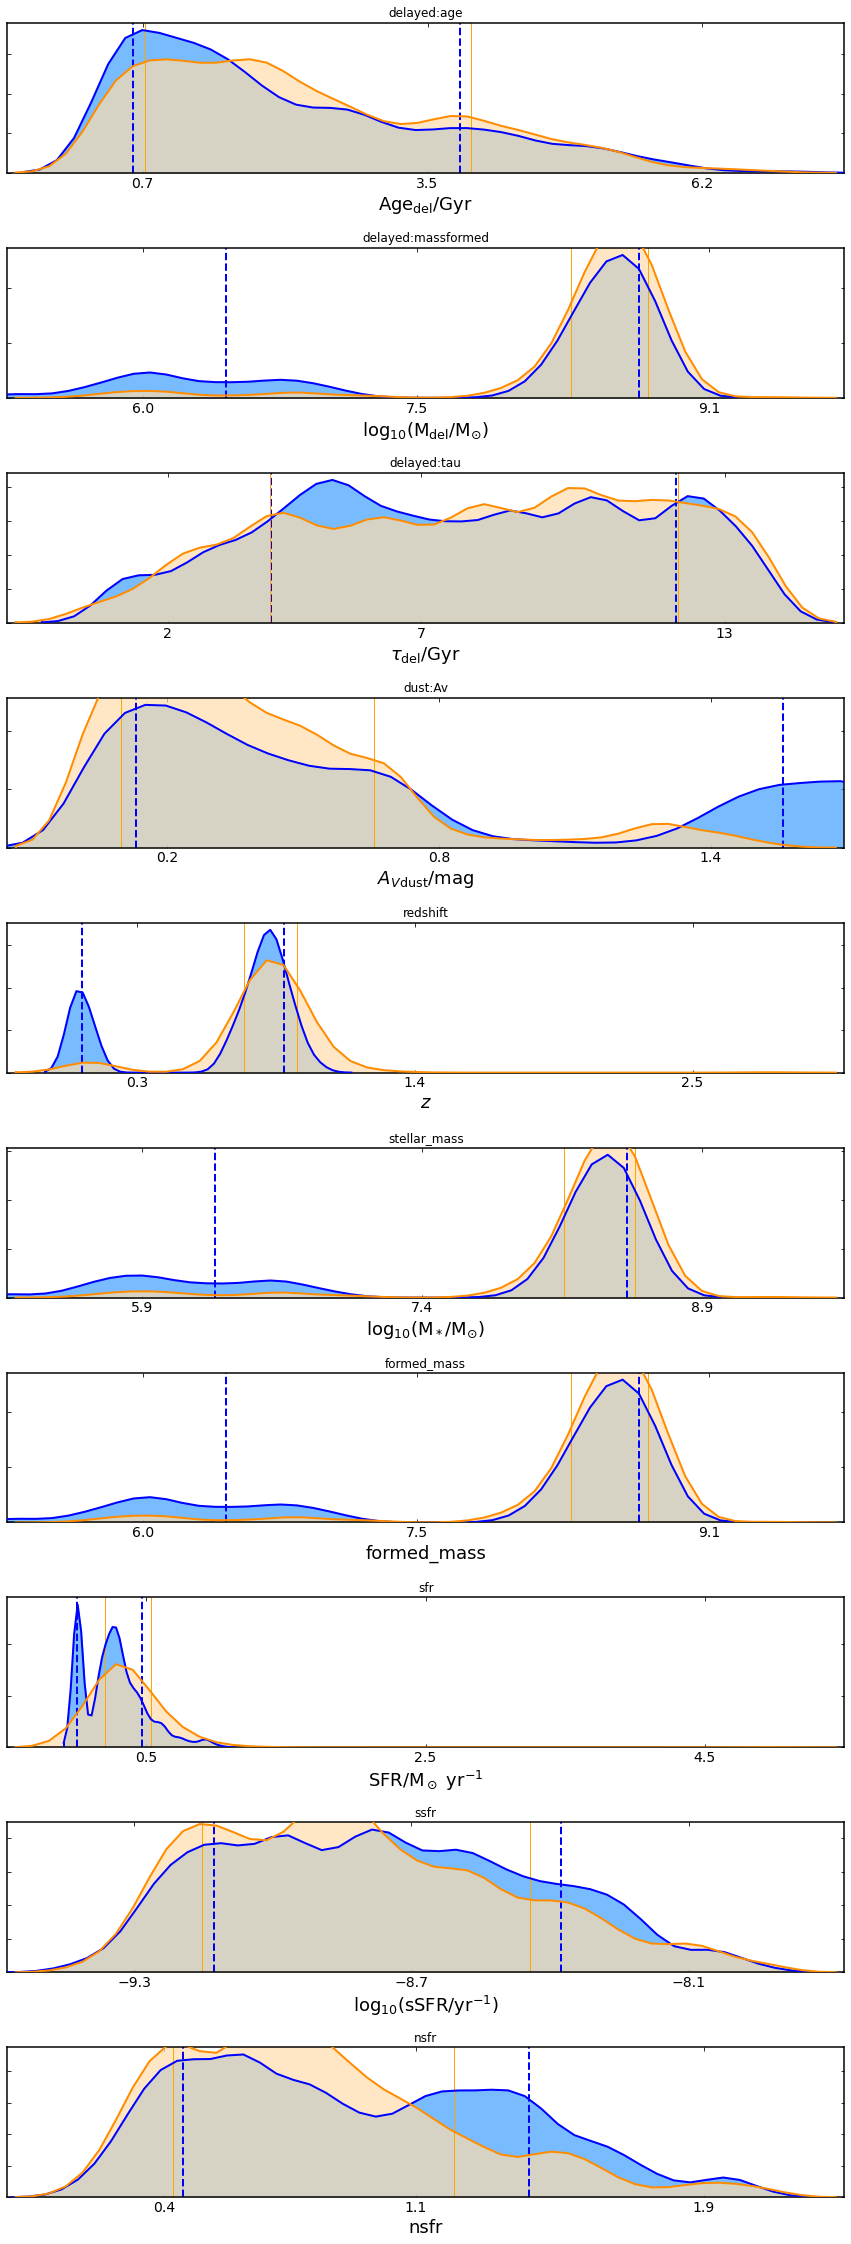

In [188]:
#mkaing a fig object
fig = plt.figure(figsize=(15, 40))

#getting gridspec layout
gs = mpl.gridspec.GridSpec(10, 10, hspace=.5, wspace=2)

#making an axis object
#ax1 = plt.subplot(gs[:4, :])

axes = []
for i in range(10):
    axes.append(plt.subplot(gs[i, :10]))
    pipes.plotting.hist1d(post_quantities[galaxy_properties[i]], axes[-1], smooth=True, percentiles=False, color='blue')#, color = 'red' )#, label=galaxy_properties[i])

    axes[-1].axvline(percentile_whole[i][0], linewidth=2, linestyle= '--', color = 'blue')
    axes[-1].axvline(percentile_whole[i][1], linewidth=2, linestyle= '--', color = 'blue')
    
    pipes.plotting.hist1d(post_quantities_half[galaxy_properties[i]], axes[-1], smooth=True, label=galaxy_properties[i], percentiles=False)
    
    axes[-1].axvline(percentile_half[i][0], linewidth=1, linestyle= '-', color = 'orange')
    axes[-1].axvline(percentile_half[i][1], linewidth=1, linestyle= '-', color = 'orange')
    axes[-1].set_title(galaxy_properties[i])

In [191]:
percentile_diff_whole = np.array([percentile_whole[i][1] - percentile_whole[i][0] for i in range(10)])
percentile_diff_half = np.array([percentile_half[i][1] - percentile_half[i][0] for i in range(10)])

In [211]:
ratio_diff = percentile_diff_half/percentile_diff_whole

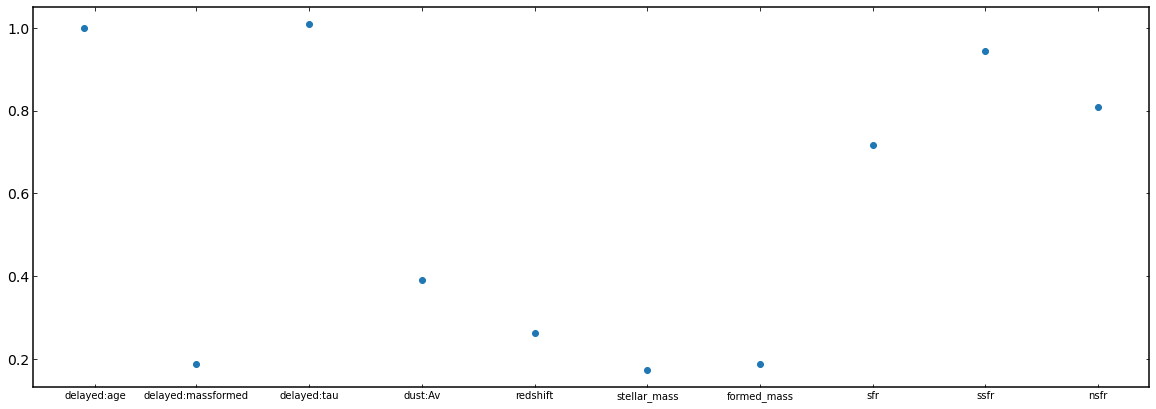

In [212]:
plt.figure(figsize = (20, 7))
plt.plot(ratio_diff, 'o')
plt.xticks(ticks=[.1, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels = galaxy_properties, size = 10)
plt.show()

AttributeError: 'posterior' object has no attribute 'model_galaxy'

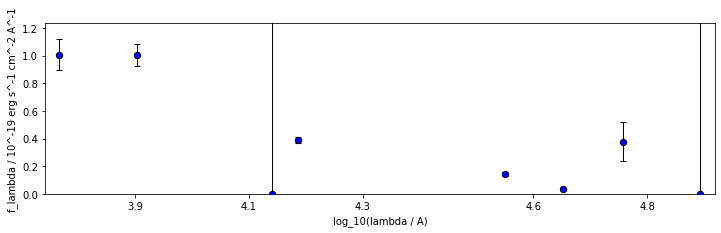

In [35]:
fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(8, 4, hspace=3., wspace=0.1)

ax1_ = plt.subplot(gs[:4, :])

pipes.plotting.add_observed_photometry(fit_cosmos.galaxy, ax1_, zorder=10)
pipes.plotting.add_photometry_posterior(fit_cosmos, ax1_)

ax2_ = plt.subplot(gs[4:, :])

pipes.plotting.add_observed_photometry(fit_half_cosmos.galaxy, ax2_, zorder=10)
pipes.plotting.add_photometry_posterior(fit_half_cosmos, ax2_)

In [37]:
fit_half_cosmos.posterior.model_galaxy

AttributeError: 'posterior' object has no attribute 'model_galaxy'

In [44]:
galaxy_cosmos1 = pipes.galaxy(543, load_cosmos_data, spectrum_exists=False, filt_list = cosmos_filt)
galaxy_halfcosmos1 = pipes.galaxy(543, load_halfcosmos_data, spectrum_exists=False, filt_list = half_cosmos_filt)

In [45]:
fit_cosmos1 = pipes.fit(galaxy_cosmos1, fit_instructions)

In [46]:
fit_cosmos1.fit()


Bagpipes: fitting object 543


Completed in 88.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.587      1.417      2.987
delayed:massformed             8.168      8.376      8.591
delayed:metallicity            1.358      2.053      2.381
delayed:tau                    3.829      8.423     12.110
dust:Av                        0.097      0.298      0.584
redshift                       0.757      0.849      0.959




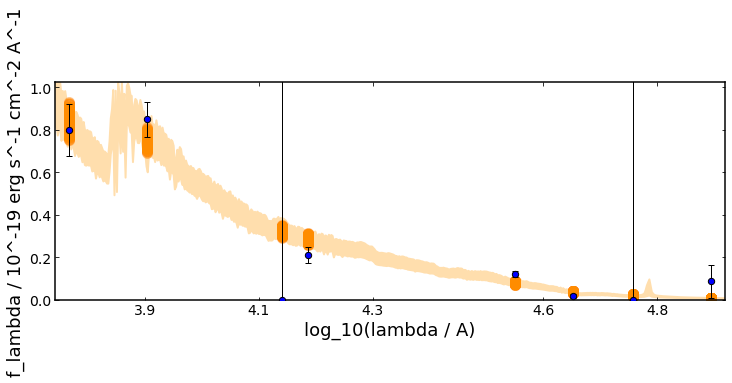

In [47]:
fig_cosmos1 = fit_cosmos1.plot_spectrum_posterior(save=False, show=True)

In [56]:
fit_half_cosmos1 = pipes.fit(galaxy_halfcosmos1, fit_instructions)

In [58]:
fit_half_cosmos1.fit()


Bagpipes: fitting object 543


Completed in 75.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.262      0.832      2.242
delayed:massformed             8.001      8.303      8.614
delayed:metallicity            1.336      2.052      2.375
delayed:tau                    3.453      8.069     12.008
dust:Av                        0.105      0.327      0.597
redshift                       0.781      0.887      1.056




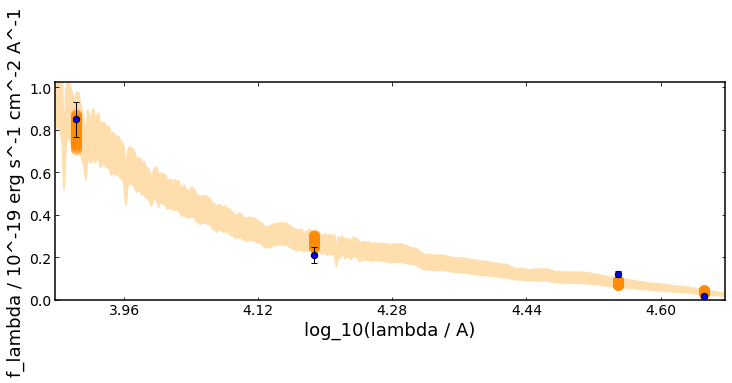

In [59]:
fig_half_cosmos1 = fit_half_cosmos1.plot_spectrum_posterior(save=False, show=True)

In [63]:
galaxy_properties

['delayed:age',
 'delayed:massformed',
 'delayed:tau',
 'dust:Av',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr']

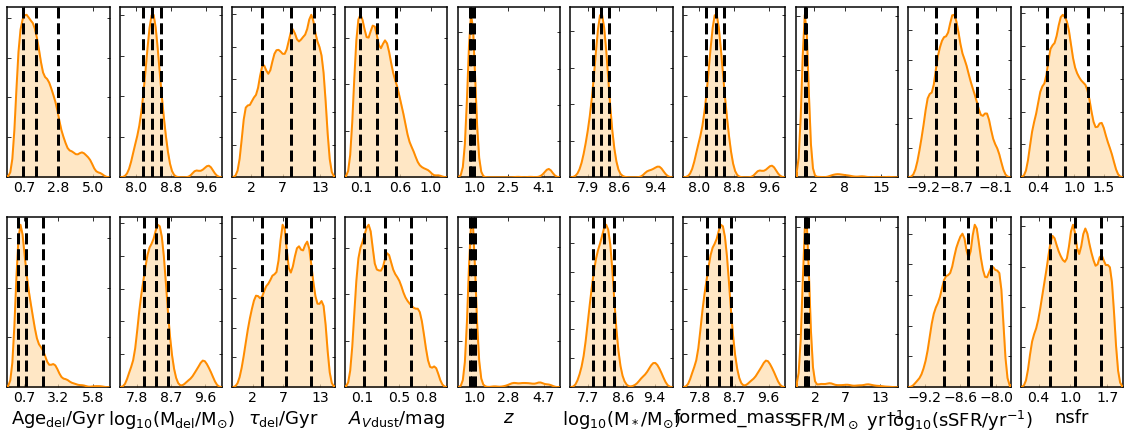

In [64]:
#mkaing a fig object
fig = plt.figure(figsize=(20, 7))

#getting gridspec layout
gs = mpl.gridspec.GridSpec(8, 10, hspace=3., wspace=0.1)

#making an axis object
ax1 = plt.subplot(gs[:4, :])

#posterior quantities (histograms)
post_quantities = dict(zip(galaxy_properties, [fit_cosmos1.posterior.samples[l] for l in galaxy_properties]))

axes1 = []
for i in range(10):
    axes1.append(plt.subplot(gs[:4, i]))
    pipes.plotting.hist1d(post_quantities[galaxy_properties[i]], axes1[-1], smooth=True)#, label=galaxy_properties[i])

#posterior quantities (histograms)
post_quantities_half = dict(zip(galaxy_properties, [fit_half_cosmos1.posterior.samples[l] for l in galaxy_properties]))

axes1_ = []
for i in range(10):
    axes1_.append(plt.subplot(gs[4:, i]))
    pipes.plotting.hist1d(post_quantities_half[galaxy_properties[i]], axes1_[-1], smooth=True, label=galaxy_properties[i])



In [127]:
path = 'pipes/filters'
cosmos_filters = [path +'/HSC_Filters/HSC_g_filt.txt', path +'/HSC_Filters/HSC_r_filt.txt', path +'/HSC_Filters/HSC_i_filt.txt', path +'/HSC_Filters/HSC_z_filt.txt', 
             path +'/IRAC_Filters/IRAC_36_filt.txt', path +'/IRAC_Filters/IRAC_45_filt.txt']

In [128]:
path = 'pipes/filters'
half_cosmos_filters = [path +'/HSC_Filters/HSC_g_filt.txt', path +'/HSC_Filters/HSC_i_filt.txt', 
             path +'/IRAC_Filters/IRAC_36_filt.txt', path +'/IRAC_Filters/IRAC_45_filt.txt']

In [129]:
#Model Building 
model = {}
model['age'] = (.01, 13)
model['tau'] = (.02, 14)
model["metallicity"] = (0., 2.5)   
model["massformed"] = (1., 13.)  

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

#more complex dust modeling
##dust["qpah"] = (.01, 5.)          # PAH mass fraction
#dust["umin"] = (0., 4.)         # Lower limit of starlight intensity distribution
#dust["gamma"] = (0., 1.)      # Fraction of stars at umin

#nebular = {}
#nebular["logU"] = (1, 4.)


fit_instructions = {}
fit_instructions['delayed'] = model
fit_instructions['redshift'] = (0., 10)
fit_instructions['dust'] = dust
#fit_instructions['nebular'] = nebular

In [138]:
def load_cosmos_data(ID):
    '''
    This function gets passed into the Bagpipes fit class and what this will return
    is photometry data in the form of a 2D array with 2 columns w/ column1 = fluxes
    and column2 = flux_err.
    
    Parameter
    -----------------
    ID: string, float, int representing the ID number of the target you want to fit 
    
    Returns
    -----------------
    phot_2d_arr: 2d array of flux and flux errors for the filters I have.
    '''
    
    #getting the row value index
    row = int(ID) - 1
    
    #making empty list to hold flux and flux_err
    flux = []
    flux_err = []
    
    #filters in the dataframe
    filters = my_science_filters
    
    #looping through the filters in the dataframe columns
    for filt in filters:
        
        #if it is an error append to the error list
        if 'e_' in filt:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux_err.append(proper_f)
        else:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux.append(proper_f)
    
    #making the two list into a 2d array
    phot_2d_arr = np.c_[flux, flux_err]
    
    #checking to see if I got some negative values cause that is no bueno and if I do
    #i set flux = 0 and blow up the error to a really high number
    
    for idx in range(len(phot_2d_arr)):
        if phot_2d_arr[idx][0] < 0 or phot_2d_arr[idx][1] < 0:
            phot_2d_arr[idx] = np.array([0, 9e99]) 
    
    return phot_2d_arr

In [147]:
my_science_filters = ['f_G', 'e_G', 'f_R', 'e_R', 'f_I', 'e_I', 
                   'f_Z', 'e_Z', 'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2']

In [148]:
galaxy_cosmos = pipes.galaxy(500, load_cosmos_data, spectrum_exists=False, filt_list = cosmos_filters)

In [151]:
fit_cosmos_science = pipes.fit(galaxy_cosmos, fit_instructions)

In [152]:
fit_cosmos_science.fit()


Bagpipes: fitting object 500


Completed in 71.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.671      1.567      2.527
delayed:massformed             9.097      9.392      9.625
delayed:metallicity            0.540      1.344      2.123
delayed:tau                    2.908      7.693     12.136
dust:Av                        0.190      0.368      0.589
redshift                       1.603      2.015      2.434




In [153]:
#posterior quantities (histograms)
post_quantities_science = dict(zip(galaxy_properties, [fit_cosmos_science.posterior.samples[l] for l in galaxy_properties]))
#post_quantities_half = dict(zip(galaxy_properties, [fit_half_cosmos.posterior.samples[l] for l in galaxy_properties]))

In [149]:
half_my_science_filters = ['f_G', 'e_G', 'f_I', 'e_I', 
                      'f_IRAC1', 'e_IRAC1', 'f_IRAC2', 'e_IRAC2']

In [154]:
def load_half_cosmos_data(ID):
    '''
    This function gets passed into the Bagpipes fit class and what this will return
    is photometry data in the form of a 2D array with 2 columns w/ column1 = fluxes
    and column2 = flux_err.
    
    Parameter
    -----------------
    ID: string, float, int representing the ID number of the target you want to fit 
    
    Returns
    -----------------
    phot_2d_arr: 2d array of flux and flux errors for the filters I have.
    '''
    
    #getting the row value index
    row = int(ID) - 1
    
    #making empty list to hold flux and flux_err
    flux = []
    flux_err = []
    
    #filters in the dataframe
    filters = half_my_science_filters
    
    #looping through the filters in the dataframe columns
    for filt in filters:
        
        #if it is an error append to the error list
        if 'e_' in filt:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux_err.append(proper_f)
        else:
            f_obs = df.loc[row][filt]
            proper_f = correct_flux(f_obs)
            flux.append(proper_f)
    
    #making the two list into a 2d array
    phot_2d_arr = np.c_[flux, flux_err]
    
    #checking to see if I got some negative values cause that is no bueno and if I do
    #i set flux = 0 and blow up the error to a really high number
    
    for idx in range(len(phot_2d_arr)):
        if phot_2d_arr[idx][0] < 0 or phot_2d_arr[idx][1] < 0:
            phot_2d_arr[idx] = np.array([0, 9e99]) 
    
    return phot_2d_arr

In [155]:
galaxy_cosmos = pipes.galaxy(500, load_half_cosmos_data, spectrum_exists=False, filt_list = half_cosmos_filters)

In [156]:
fit_half_cosmos_science = pipes.fit(galaxy_cosmos, fit_instructions)

In [157]:
fit_half_cosmos_science.fit()


Bagpipes: fitting object 500


Completed in 54.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.884      1.890      3.012
delayed:massformed             9.007      9.307      9.565
delayed:metallicity            0.438      1.238      2.038
delayed:tau                    3.270      7.416     11.879
dust:Av                        0.177      0.353      0.552
redshift                       1.282      1.710      2.275




In [158]:
post_quantities_half_science = dict(zip(galaxy_properties, [fit_half_cosmos_science.posterior.samples[l] for l in galaxy_properties]))

In [160]:
percentile_whole_science = []
percentile_half_science = []

for i in range(10):
    
    percentile_whole_science.append(np.percentile(post_quantities_science[galaxy_properties[i]], [16, 84]))
    percentile_half_science.append(np.percentile(post_quantities_half_science[galaxy_properties[i]], [16, 84]))

In [161]:
fifty_percentile_whole_science = []
fifty_percentile_half_science = []

for i in range(10):
    
    fifty_percentile_whole_science.append(np.percentile(post_quantities_science[galaxy_properties[i]], 50))
    fifty_percentile_half_science.append(np.percentile(post_quantities_half_science[galaxy_properties[i]], 50))

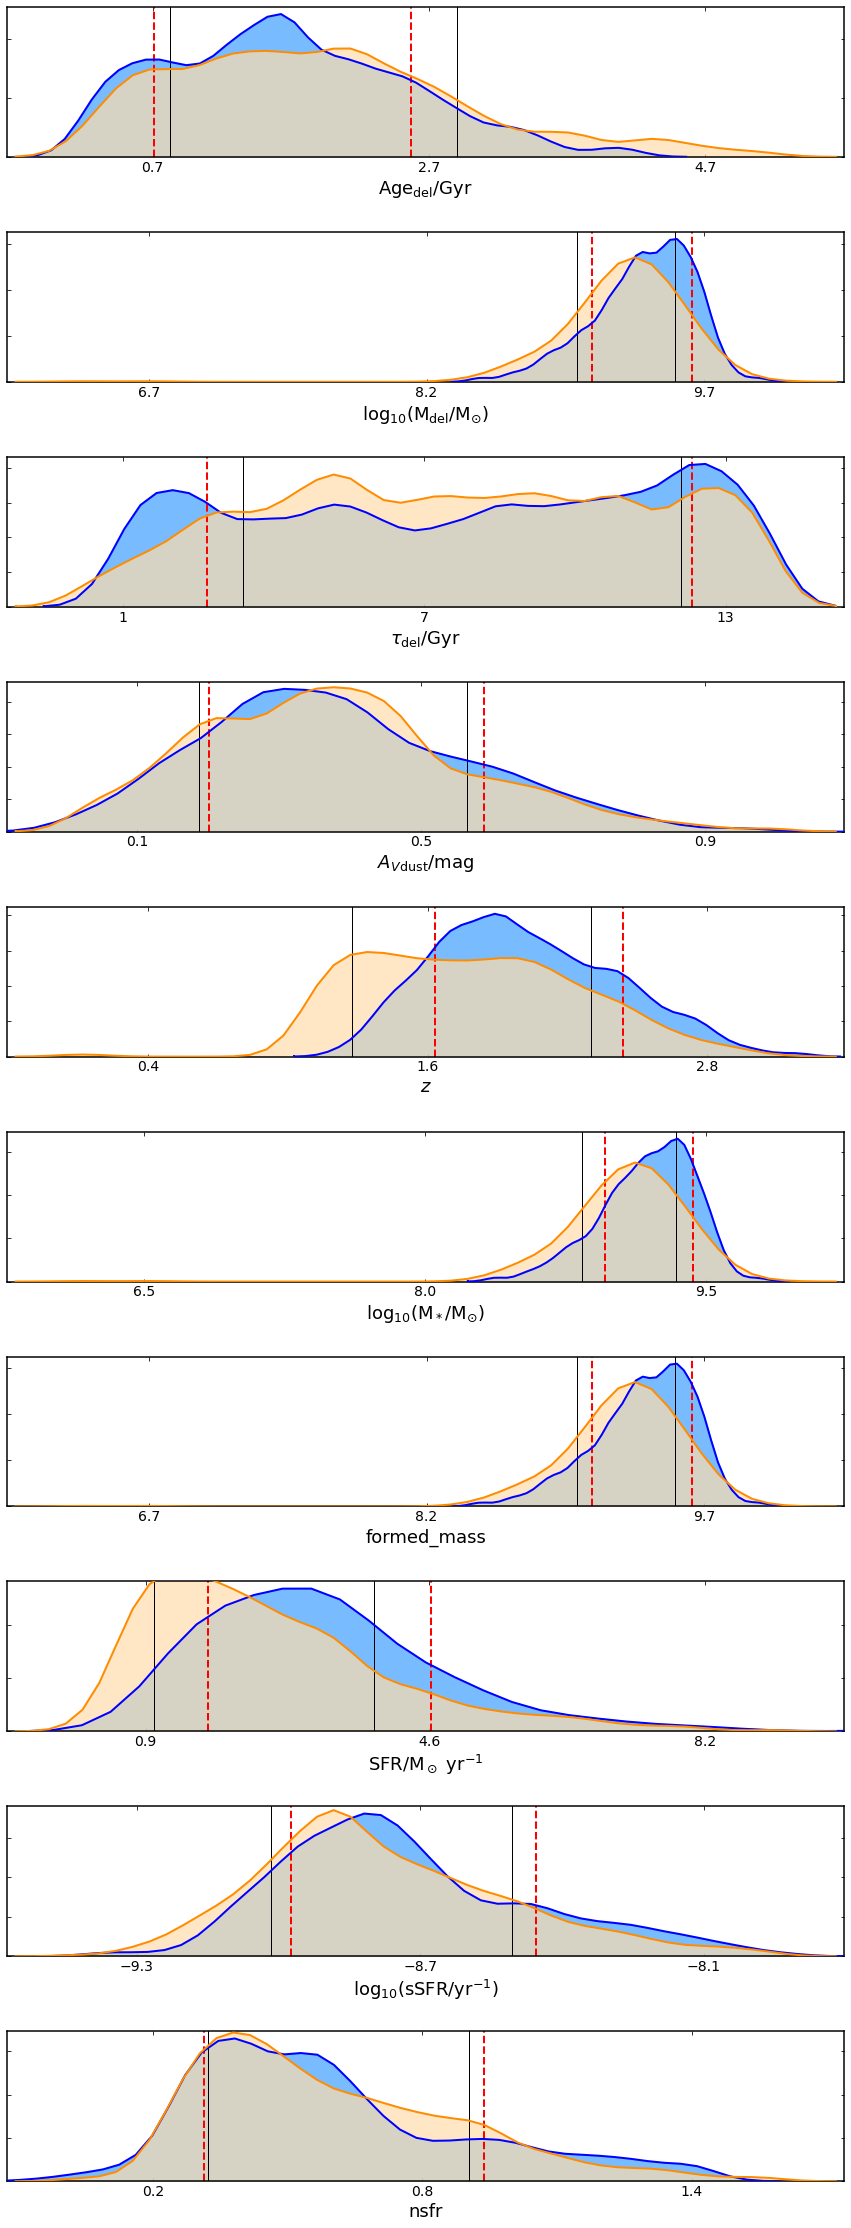

In [162]:
#mkaing a fig object
fig = plt.figure(figsize=(15, 40))

#getting gridspec layout
gs = mpl.gridspec.GridSpec(10, 10, hspace=.5, wspace=2)

#making an axis object
#ax1 = plt.subplot(gs[:4, :])

axes = []
for i in range(10):
    axes.append(plt.subplot(gs[i, :10]))
    pipes.plotting.hist1d(post_quantities_science[galaxy_properties[i]], axes[-1], smooth=True, percentiles=False, color='blue')#, color = 'red' )#, label=galaxy_properties[i])

    axes[-1].axvline(percentile_whole_science[i][0], linewidth=2, linestyle= '--', color = 'red')
    axes[-1].axvline(percentile_whole_science[i][1], linewidth=2, linestyle= '--', color = 'red')
    
    pipes.plotting.hist1d(post_quantities_half_science[galaxy_properties[i]], axes[-1], smooth=True, label=galaxy_properties[i], percentiles=False)
    
    axes[-1].axvline(percentile_half_science[i][0], linewidth=1, linestyle= '-', color = 'black')
    axes[-1].axvline(percentile_half_science[i][1], linewidth=1, linestyle= '-', color = 'black')
    #axes[-1].set_title(galaxy_properties[i])

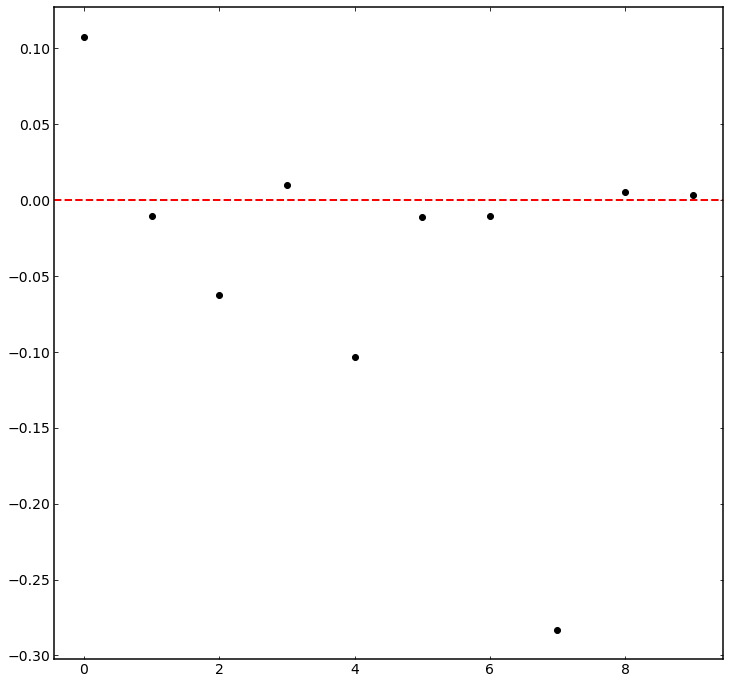

In [169]:
rel_diff = (np.array(fifty_percentile_half_science) - np.array(fifty_percentile_whole_science))/np.array(fifty_percentile_whole_science)

plt.figure(figsize = (12, 12))
plt.plot(rel_diff, 'o', color = 'black')
plt.axhline(0, linestyle= '--', color = 'red')
#plt.xticks(ticks=[.1, 1, 3, 4, 5, 6, 7, 8, 9, 10], labels = galaxy_properties, size = 10)

In [186]:
print('                         half  ---------------- Whole')
print()
for i in range(10):
    
    print('%20s     %.3f ---------------- %.3f' %(galaxy_properties[i], fifty_percentile_half_science[i], fifty_percentile_whole_science[i]))

                         half  ---------------- Whole

         delayed:age     1.793 ---------------- 1.619
  delayed:massformed     9.309 ---------------- 9.410
         delayed:tau     7.602 ---------------- 8.111
             dust:Av     0.364 ---------------- 0.360
            redshift     1.767 ---------------- 1.970
        stellar_mass     9.107 ---------------- 9.212
         formed_mass     9.309 ---------------- 9.410
                 sfr     2.160 ---------------- 3.012
                ssfr     -8.829 ---------------- -8.783
                nsfr     0.535 ---------------- 0.533
